# **LangGraph with LLM, RAG, Conditional Edges:**

In [ ]:
# install necessary libaries:

%pip install --upgrade --quiet sentence_transformers
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-google-genai langchain-chroma bs4 boto3
%pip install --upgrade --quiet langchain-aws
%pip install --upgrade --quiet langgraph langsmith langchain_anthropic

## **Example 01: Integrating LLM call in the LangGraph**

### **Load LLM:**

In [2]:
# Load the Tokens:

from google.colab import userdata
import os

os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

def load_llm(model_name:str=None):
  llm = ChatGoogleGenerativeAI(
    model=model_name if model_name else "gemini-1.0-pro",
    temperature=0.4
  )
  return llm

### **Create a Nodes:**

In [6]:
# Create Function or Component or node:

# Node: These helps to Generate Responses.
def generate_responses(query:str) -> str:
  llm = load_llm()
  response = llm.invoke(query).content
  return response

# Node: Convert The Response into Upper Case:
def convert_to_upper(response:str) -> str:
  return response.upper()

### **Create WorkFlow:**

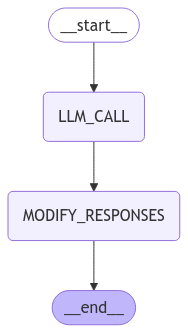

In [9]:
# Create WorkFlow:
from langgraph.graph import Graph

# Define workflow
workflow = Graph()

# Add Nodes:
workflow.add_node("LLM_CALL", generate_responses)
workflow.add_node("MODIFY_RESPONSES", convert_to_upper)

# ADD Edges to Nodes:
workflow.add_edge("LLM_CALL", "MODIFY_RESPONSES")

# Set Entry Point:
workflow.set_entry_point("LLM_CALL")

# Set Exist Point:
workflow.set_finish_point("MODIFY_RESPONSES")


# Compile the workflow:
app = workflow.compile()
app

In [10]:
app.invoke("Hi.")

'HELLO THERE! HOW CAN I ASSIST YOU TODAY?'

In [11]:
app.invoke("Tell me something about you within 3 lines.")

'I AM AN AI ASSISTANT, DESIGNED TO PROVIDE INFORMATION AND ASSIST WITH VARIOUS TASKS.\nI AM CONSTANTLY LEARNING AND EXPANDING MY KNOWLEDGE BASE TO BETTER SERVE USERS.\nI AM COMMITTED TO PROVIDING ACCURATE, HELPFUL, AND UNBIASED RESPONSES TO ALL INQUIRIES.'

In [12]:
# Stream:

query = "What is AI?"
for output in app.stream(query):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'LLM_CALL':
---
Artificial Intelligence (AI) is the simulation of human intelligence processes by machines, especially computer systems. AI research has been highly successful in developing effective techniques for solving a wide range of problems, from game playing to medical diagnosis.

AI is a branch of computer science that seeks to understand and create intelligent agents, which are systems that can reason, learn, and act autonomously. AI research has been highly successful in developing effective techniques for solving a wide range of problems, from game playing to medical diagnosis.

Some of the most important subfields of AI include:

* **Machine learning:** This field studies algorithms that allow computers to learn from data without being explicitly programmed. Machine learning algorithms are used in a wide variety of applications, such as image recognition, natural language processing, and fraud detection.
* **Natural language processing:** This field studie

## **Example 02: Integrating LLM & RAG in the LangGraph**

In [13]:
# Load the Tokens:

from google.colab import userdata
import os

os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

### **Load LLM & Embeddings:**

In [14]:
from langchain_google_genai import ChatGoogleGenerativeAI

def load_llm(model_name:str=None):
  llm = ChatGoogleGenerativeAI(
    model=model_name if model_name else "gemini-1.0-pro",
    temperature=0.4
  )
  return llm

In [ ]:
%pip install langchain-huggingface

In [ ]:
# Get the Embeddings:

from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

### **Vector Store & Retriever:**

In [ ]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [19]:
# Load, chunk and index the contents of the blog.
loader = WebBaseLoader("https://docs.smith.langchain.com/overview")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

In [20]:
# retriever:

retriever = vectorstore.as_retriever(search_kwargs=dict(k=5))

### **Type 1: To Create LangGraph WorkFlow:**

In [22]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA

In [24]:
# Create Nodes:

#
def function_1(state):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question

    complete_query = "Your task is to provide only the topic based on the user query. \
        Only output the topic among: [Japan , Sports]. Don't include reasoning. Following is the user query: " + question

    llm = load_llm()
    response = llm.invoke(complete_query)
    state['messages'].append(response.content) # appending LLM call response to the AgentState
    return state


# RAG Pipeline:
def function_2(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    template = """You are a Helpful Assistant, named Lily, designed by Dibyendu Biswas for solving the user Query. \
    Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    # prompt = ChatPromptTemplate.from_template(template)
    prompt = PromptTemplate.from_template(template)
    llm = load_llm()

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result


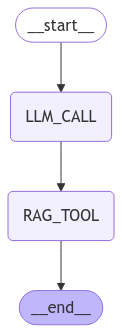

In [25]:
# Create WorkFlow:
from langgraph.graph import Graph

# Define workflow
workflow = Graph()

# Add Nodes:
workflow.add_node("LLM_CALL", function_1)
workflow.add_node("RAG_TOOL", function_2)

# Define the Edges:
workflow.add_edge("LLM_CALL", "RAG_TOOL")

# Set Entry Point:
workflow.set_entry_point("LLM_CALL")

# Set Exist Point:
workflow.set_finish_point("RAG_TOOL")

# Render or Compile the graph
app = workflow.compile()
app

In [27]:
app.invoke({"messages": ["Hi"]})

'I am sorry, but the provided context does not contain the answer to your question.'

In [28]:
app.invoke({"messages": ["What is LangSmith"]})

'LangSmith is a platform for building production-grade LLM applications.'

In [29]:
app.invoke({"messages": ["Tell me something about India"]})

'The provided context does not mention anything about India, so I cannot answer this question from the provided context.'

In [30]:
app.invoke({"messages": ["Tell me something about Japan."]})

'The provided context does not mention anything about Japan, so I cannot answer this question from the provided context.'

### **Type 02: Create LangGraph WorkFlow (only RAG)**

In [45]:
from langchain_google_genai import ChatGoogleGenerativeAI

def load_llm(model_name:str="gemini-1.5-pro"):
  llm = ChatGoogleGenerativeAI(
    model=model_name if model_name else "gemini-1.0-pro",
    temperature=0.4
  )
  return llm

In [49]:
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, FewShotPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA

In [52]:
# RAG Pipeline:
def function_1(query:str):
    # Define Few-Shot Prompt Template using Few esamples:
    few_shot_examples = [
      {'input': 'Hello', 'output': 'Hi there! How can I help you today?'},
      {'input': 'What is your name?', 'output': 'I’m ChatGPT, your assistant!'},
      {'input': 'How are you?', 'output': 'I’m doing great, thanks for asking! How about you?'},
      {'input': 'Tell me a joke', 'output': 'Why don’t skeletons fight each other? They don’t have the guts!'},
      {'input': 'What time is it?', 'output': 'I’m not able to tell the time, but you can check your device!'},
      {'input': 'Goodbye', 'output': 'Goodbye! Have a great day!'},
      {'input': 'Can you help me?', 'output': 'Of course! What do you need help with?'},
      {'input': 'What is the weather like?', 'output': 'I’m unable to check real-time weather, but you can look it up online!'},
      {'input': 'Set a reminder', 'output': 'I can’t set reminders, but I can help you with other things!'},
      {'input': 'Where are you from?', 'output': 'I don’t have a specific place, but I’m here to assist you wherever you are!'},
      {'input': 'What can you do?', 'output': 'I can answer questions, tell jokes, help with tasks, and more! What do you need today?'},
      {'input': 'Help me with math', 'output': 'Sure! What math problem would you like help with?'},
      {'input': 'I am bored', 'output': 'Let’s do something fun! Want to hear a joke or maybe try a quiz?'},
      {'input': 'What is 5 + 7?', 'output': '5 + 7 equals 12!'},
      {'input': 'How do I cook pasta?', 'output': 'Boil water, add pasta, cook for 8-12 minutes, drain, and enjoy!'},
      {'input': 'Tell me a fun fact', 'output': 'Did you know? A day on Venus is longer than a year on Venus!'},
      {'input': 'What is your favorite color?', 'output': 'I don’t have a favorite color, but I think blue is nice!'}
    ]

    # Few Shot Template:
    few_shot_template = ChatPromptTemplate.from_messages(
        [
            ("human", "{input}"),
            ("ai", "{output}")
        ]
    )
    # Few Shot Prompt:
    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=few_shot_template,
        examples=few_shot_examples,
    )

    # Write System Messages:
    system_prompt = (
        "You are an AI Assistant, named 'Lily' specializing in AI for all the students."
        "This AI Assistant Designed by Dibyendu Biswas, an AI/ML Engineer"
        "You provide clear, step-by-step explanations and encourage students to learn. "
        "If a question is unclear, ask for clarification."
        "Use four sentences maximum and keep the answer concise."
        "\n\n"
        "{context}"
    )

    # Define Final Prompt Using System prompt and Few Shot Prompt
    final_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        few_shot_prompt,
        ("user", "{input}"),
    ])

    llm = load_llm()

    retrieval_chain = (
        {"context": retriever, "input": RunnablePassthrough()}
        | final_prompt
        | llm
        | StrOutputParser()
        )

    result = retrieval_chain.invoke(query)
    return result


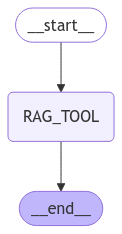

In [53]:
# Create a WorkFlow:

from langgraph.graph import Graph, START, END


# Define WorkFlow:
workflow = Graph()

# Add Nodes:
workflow.add_node("RAG_TOOL", function_1)

# Define the Edges:
workflow.add_edge(START, "RAG_TOOL")
workflow.add_edge("RAG_TOOL", END)

# Compile the WorkFlow:
app = workflow.compile()
app

In [54]:
app.invoke("Hi")

'Hi there! How can I help you today?'

In [55]:
app.invoke("Tell me something about yourself.")

"I'm Lily, an AI assistant designed by Dibyendu Biswas to help students learn.  I can provide concise explanations and answer your questions clearly.  Ask me anything!"

In [57]:
app.invoke("Are you Stupid?")

'I’m still under development, but I try my best to help!'

In [58]:
app.invoke("What is LangSmith? Abd Why it is required?")

"LangSmith is a platform for building, testing, and monitoring production-grade LLM applications.  It's needed to ensure quality, identify issues, and improve the performance of your LLM apps."

## **Example 03: Conditional Edges (DAG)**

* Either **LLM_CALL** or **RAG_CALL**

### **Load LLM & Embeddings:**

In [72]:
from langchain_google_genai import ChatGoogleGenerativeAI

def load_llm(model_name:str="gemini-1.5-pro"):
  llm = ChatGoogleGenerativeAI(
    model=model_name if model_name else "gemini-1.0-pro",
    # temperature=0.4
  )
  return llm

llm = load_llm()

In [60]:
# Get the Embeddings:

from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

### **Vector Store:**

In [61]:
# Load, chunk and index the contents of the blog.
loader = WebBaseLoader("https://docs.smith.langchain.com/overview")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

In [ ]:
# retriever:

retriever = vectorstore.as_retriever(search_kwargs=dict(k=5))

### **LangGraph Integration:**

In [62]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage

In [63]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [66]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel , Field



class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    #Reasoning: str = Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser

PydanticOutputParser(pydantic_object=<class '__main__.TopicSelectionParser'>)

In [67]:
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}}, "required": ["Topic"]}\n```'

#### **Create Conditional Agent Node:**

In [71]:
# A Conditional Agent Node:

def function(state):
    # print('-> Calling Conditional Agent ->')
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question

    templete = """ Your task is to provide only the topic based on the user query. \
    Only output the topic among: [LangChain, LLM, Agent, LangSmith, Not Related]. \
    Don't include reasoning. \
    Following is the user query:  {question} \
    {format_instructions} """
    prompt = PromptTemplate(template=templete,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain = prompt | llm | parser

    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    # print(response)

    return {"messages": [response.Topic]}



# Invoke
function({"messages": ["Tell me Something About India"]}), function({"messages": ["Tell me Something About LangChain, LangSmith, LLM, etc."]})

({'messages': ['Not Related']}, {'messages': ['LangChain']})

#### **Create Nodes:**

In [82]:
# Create Node: LLM_CALL, that call only llm to get response.

def function_1(state):
    # print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


function_1({"messages": ["Tell me something about India"]})

{'messages': ["India is a vast and diverse country located in South Asia. It's the world's second-most populous country and the seventh-largest by land area.  Known for its rich history, vibrant culture, and diverse landscapes, India offers something for everyone.  Here are a few key points:\n\n* **Ancient Civilization:**  India is home to one of the world's oldest civilizations, the Indus Valley Civilization.  Its history is filled with powerful empires, religious movements, and significant contributions to art, science, and mathematics.\n* **Cultural Hub:** India is incredibly diverse, with 28 states and 8 union territories, each with its own unique language, customs, and traditions.  This cultural richness is reflected in its music, dance, literature, and cuisine.\n* **Religious Diversity:**  India is a secular nation with a variety of religions practiced, including Hinduism, Islam, Sikhism, Christianity, Buddhism, Jainism, and Zoroastrianism.  This religious diversity has shaped th

In [73]:
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate, FewShotPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import RetrievalQA

In [74]:
# Create Node: RAG_Tool, that call the knowledgebase for generating response.


# RAG Pipeline:
def function_2(state):
    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Define Few-Shot Prompt Template using Few esamples:
    few_shot_examples = [
      {'input': 'Hello', 'output': 'Hi there! How can I help you today?'},
      {'input': 'What is your name?', 'output': 'I’m ChatGPT, your assistant!'},
      {'input': 'How are you?', 'output': 'I’m doing great, thanks for asking! How about you?'},
      {'input': 'Tell me a joke', 'output': 'Why don’t skeletons fight each other? They don’t have the guts!'},
      {'input': 'What time is it?', 'output': 'I’m not able to tell the time, but you can check your device!'},
      {'input': 'Goodbye', 'output': 'Goodbye! Have a great day!'},
      {'input': 'Can you help me?', 'output': 'Of course! What do you need help with?'},
      {'input': 'What is the weather like?', 'output': 'I’m unable to check real-time weather, but you can look it up online!'},
      {'input': 'Set a reminder', 'output': 'I can’t set reminders, but I can help you with other things!'},
      {'input': 'Where are you from?', 'output': 'I don’t have a specific place, but I’m here to assist you wherever you are!'},
      {'input': 'What can you do?', 'output': 'I can answer questions, tell jokes, help with tasks, and more! What do you need today?'},
      {'input': 'Help me with math', 'output': 'Sure! What math problem would you like help with?'},
      {'input': 'I am bored', 'output': 'Let’s do something fun! Want to hear a joke or maybe try a quiz?'},
      {'input': 'What is 5 + 7?', 'output': '5 + 7 equals 12!'},
      {'input': 'How do I cook pasta?', 'output': 'Boil water, add pasta, cook for 8-12 minutes, drain, and enjoy!'},
      {'input': 'Tell me a fun fact', 'output': 'Did you know? A day on Venus is longer than a year on Venus!'},
      {'input': 'What is your favorite color?', 'output': 'I don’t have a favorite color, but I think blue is nice!'}
    ]

    # Few Shot Template:
    few_shot_template = ChatPromptTemplate.from_messages(
        [
            ("human", "{input}"),
            ("ai", "{output}")
        ]
    )
    # Few Shot Prompt:
    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=few_shot_template,
        examples=few_shot_examples,
    )

    # Write System Messages:
    system_prompt = (
        "You are an AI Assistant, named 'Lily' specializing in AI for all the students."
        "This AI Assistant Designed by Dibyendu Biswas, an AI/ML Engineer"
        "You provide clear, step-by-step explanations and encourage students to learn. "
        "If a question is unclear, ask for clarification."
        "Use four sentences maximum and keep the answer concise."
        "\n\n"
        "{context}"
    )

    # Define Final Prompt Using System prompt and Few Shot Prompt
    final_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        few_shot_prompt,
        ("user", "{input}"),
    ])

    llm = load_llm()

    retrieval_chain = (
        {"context": retriever, "input": RunnablePassthrough()}
        | final_prompt
        | llm
        | StrOutputParser()
        )

    result = retrieval_chain.invoke(question)
    return {"messages": [result]}


function_2({"messages": ["What is LangSmith?"]})

{'messages': ['LangSmith is a platform for building and improving production-grade LLM applications.  It allows you to observe, evaluate, and debug your LLM apps.  It integrates seamlessly with LangChain.']}

#### **Create Router: that either call LLM or RAG Tool:**

* Either **LLM_CALL** or **RAG_TOOL**.

In [83]:
# Create a Router Function which route the Component/Function call in the Acyclic Graph:

def router(state):
    # print('-> Router ->')

    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'LangChain' in last_message or 'LLM' in last_message or 'Agent' in last_message  or 'LangSmith' in last_message:
        return 'RAG_Call'
    else:
        return 'LLM_Call'

#### **Create WorkFlow:**

In [76]:
from langgraph.graph import StateGraph, END

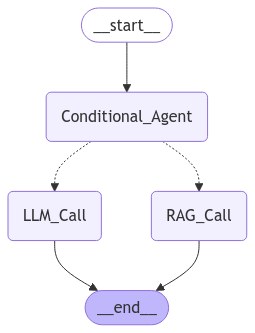

In [84]:
workflow = StateGraph(AgentState) ### StateGraph with AgentState

# Add Nodes:
workflow.add_node("Conditional_Agent", function)
workflow.add_node("LLM_Call", function_1)
workflow.add_node("RAG_Call", function_2)


# Set an Entry Point:
workflow.set_entry_point("Conditional_Agent")



# Define Conditional Edges, that is controlled by router:
workflow.add_conditional_edges(
    "Conditional_Agent", # Where Graph Start
    router, # router function to determine which node is called
    {
        "LLM_Call": "LLM_Call",
        "RAG_Call": "RAG_Call"
    }
)



# Add Edges: LLM_CALL -> END & RAG_CALL -> END:
workflow.add_edge("LLM_Call", END)
workflow.add_edge("RAG_Call", END)



# Compile the WorkFlow:
app = workflow.compile()
app

In [80]:
app.invoke({"messages": ["Tell me about LangSmith"]})

LangSmith


{'messages': ['Tell me about LangSmith',
  'LangSmith',
  'LangSmith is a platform for building and managing production-grade LLM applications.  It helps you monitor, evaluate, and improve your LLM apps.  This allows you to ship faster and with more confidence.']}

In [85]:
app.invoke({"messages": ["Tell me about India"]})

Not Related


{'messages': ['Tell me about India',
  'Not Related',
  "India is a vast and diverse country located in South Asia. It's the seventh-largest country by area and the second-most populous, with over 1.4 billion people.  Here's a glimpse into some key aspects:\n\n**Geography and Environment:**\n\n* **Himalayas:**  India is bordered by the towering Himalayas in the north, which include some of the world's highest peaks like Mount Everest (though its summit lies in Nepal).\n* **Ganges River:** The Ganges, a sacred river for Hindus, flows through northern India and is vital for agriculture and spiritual practices.\n* **Diverse Landscapes:** From the snowy Himalayas to the Thar Desert, coastal plains, and tropical forests, India boasts a wide range of landscapes and ecosystems.\n* **Monsoon Season:**  India experiences a monsoon season, bringing heavy rainfall crucial for agriculture but also causing floods in some areas.\n* **Environmental Challenges:**  Rapid industrialization and populatio

In [86]:
app.invoke({"messages": ["Hi."]})

Not Related


{'messages': ['Hi.', 'Not Related', 'Hi. How can I help you?']}